Image Classification via fine-tuning with EfficientNet

Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#image-classification-via-finetuning-with-efficientnet

Setup & Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection code
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy") # if TPU is not available
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Loading Data

In [ ]:
import tensorflow_datasets as tfds #importing tensorflow dataset

batch_size = 64

dataset_name = "stanford_dogs" #Stanford Dogs Dataset available at http://vision.stanford.edu/aditya86/ImageNetDogs/main.html
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "test"], with_info=True, as_supervised=True)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0I6Y3R/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete0I6Y3R/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
# EfficientNetB0 = 224
# EfficientNetB1 = 240
# EfficientNetB2 = 260
# EfficientNetB3 = 300
# EfficientNetB4 = 380
# EfficientNetB5 = 456
# EfficientNetB6 = 528
# EfficientNetB7 = 600
IMG_SIZE = 224

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

Visualizing Data

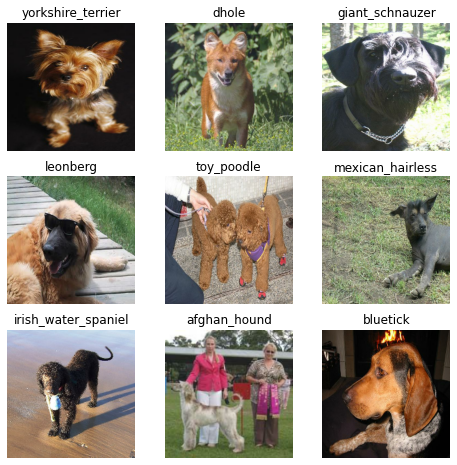

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

plt.figure(figsize=(8,8))
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


Data Augmentation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


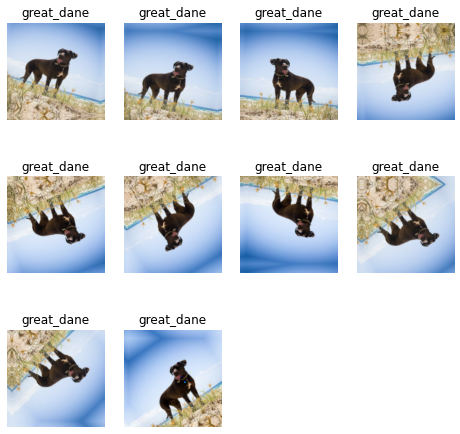

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

plt.figure(figsize=(8,8))
for image, label in ds_train.take(10):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

Prepare Inputs

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

Training a Model from Scratch

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 25  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 120)               4203291   
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/25
187/187 - 163s - loss: 4.9638 - accuracy: 0.0103 - val_loss: 4.9405 - val_accuracy: 0.0100
Epoch 2/25
187/187 - 122s - loss: 4.6575 - accuracy: 0.0209 - val_loss: 5.0564 - val_accuracy: 0.0090
Epoch 3/25
187/187 - 121s - loss: 4.4508 - accuracy: 0.0334 - val_loss: 5.0146 - val_accuracy: 0.0211
Epoch 4/25
187/187 - 121s - loss: 4.2803 - accuracy: 0.0445 - val_loss

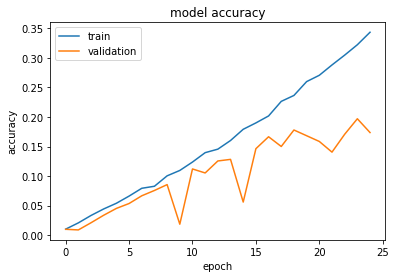

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

Saving First Model

In [ ]:
model.save('drive/MyDrive/tugasdl/savedmodel/model1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Transfer Learning from Pre-trained Weights



In [ ]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


16711680/16705208 [==============================] - 1s 0us/step
Epoch 1/25
187/187 - 46s - loss: 3.5435 - accuracy: 0.3717 - val_loss: 1.0278 - val_accuracy: 0.6862
Epoch 2/25
187/187 - 36s - loss: 1.8649 - accuracy: 0.5226 - val_loss: 0.8167 - val_accuracy: 0.7479
Epoch 3/25
187/187 - 37s - loss: 1.5512 - accuracy: 0.5740 - val_loss: 0.7749 - val_accuracy: 0.7687
Epoch 4/25
187/187 - 37s - loss: 1.4357 - accuracy: 0.5988 - val_loss: 0.7829 - val_accuracy: 0.7657
Epoch 5/25
187/187 - 37s - loss: 1.3884 - accuracy: 0.6089 - val_loss: 0.7929 - val_accuracy: 0.7628
Epoch 6/25
187/187 - 37s - loss: 1.3461 - accuracy: 0.6171 - val_loss: 0.8569 - val_accuracy: 0.7488
Epoch 7/25
187/187 - 37s - loss: 1.3263 - accuracy: 0.6266 - val_loss: 0.7681 - val_accuracy: 0.7710
Epoch 8/25
187/187 - 37s - loss: 1.2963 - accuracy: 0.6344 - val_loss: 0.8313 - val_accuracy: 0.7580
Epoch 9/25
187/187 - 37s - loss: 1.3228 - accuracy: 0.6303 - val_loss: 0.8167 - val_accuracy: 0.7603
Epoch 10/25
187/187 - 37s 

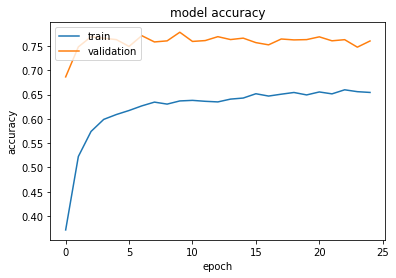

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Epoch 1/25
187/187 - 47s - loss: 0.9880 - accuracy: 0.7110 - val_loss: 0.7696 - val_accuracy: 0.7892
Epoch 2/25
187/187 - 39s - loss: 0.8540 - accuracy: 0.7472 - val_loss: 0.7673 - val_accuracy: 0.7870
Epoch 3/25
187/187 - 40s - loss: 0.7753 - accuracy: 0.7672 - val_loss: 0.7643 - val_accuracy: 0.7902
Epoch 4/25
187/187 - 39s - loss: 0.7118 - accuracy: 0.7789 - val_loss: 0.7582 - val_accuracy: 0.7877
Epoch 5/25
187/187 - 39s - loss: 0.6892 - accuracy: 0.7867 - val_loss: 0.7605 - val_accuracy: 0.7902
Epoch 6/25
187/187 - 40s - loss: 0.6438 - accuracy: 0.7990 - val_loss: 0.7706 - val_accuracy: 0.7886
Epoch 7/25
187/187 - 40s - loss: 0.6127 - accuracy: 0.8091 - val_loss: 0.7804 - val_accuracy: 0.7851
Epoch 8/25
187/187 - 40s - loss: 0.5807 - accuracy: 0.8193 - val_loss: 0.7763 - val_accuracy: 0.7844
Epoch 9/25
187/187 - 40s - loss: 0.5588 - accuracy: 0.8227 - val_loss: 0.7750 - val_accuracy: 0.7875
Epoch 10/25
187/187 - 41s - loss: 0.5235 - accuracy: 0.8300 - val_loss: 0.7851 - val_accura

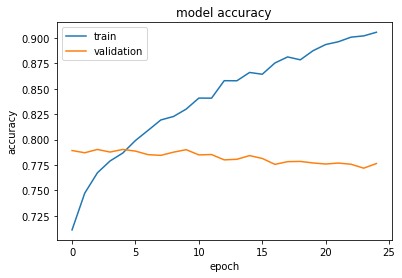

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 25  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Saving Second Model

In [ ]:
model.save('drive/MyDrive/tugasdl/savedmodel/model2.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Predicting

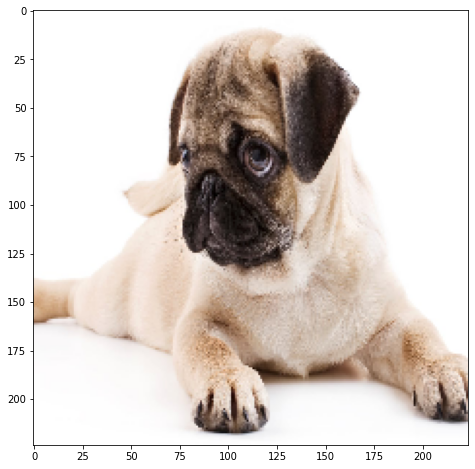

Type: pug

Probability: 98.35%


In [ ]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from skimage import transform
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

plt.figure(figsize=(8,8))   

with open("/root/tensorflow_datasets/stanford_dogs/0.2.0/label.labels.txt") as f:
  labels = f.readlines()
  f.close()

def imagepredict(img_path):
  img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
  img_array = image.img_to_array(img)
  img_batch = tf.expand_dims(img_array, axis=0)
  img_preprocessed = preprocess_input(img_batch)

  plt.imshow(img)
  plt.show()

  model = load_model('drive/MyDrive/tugasdl/savedmodel/model2.h5')
  prediction = model.predict(img_preprocessed)
  maxprediction = np.argmax(prediction)
  maxprob = 100 * np.max(prediction)
  name = labels[maxprediction]
  name = str(name.split('-')[1])

  print("Type: " + name)
  print("Probability: " + str(round(maxprob,2)) + "%")

imagepredict("drive/MyDrive/tugasdl/test images/5.jpg")